<a href="https://colab.research.google.com/github/peeyushsinghal/DA-CV/blob/main/da_mnist_mnistm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Dataset MNIST : Dataloader (used torchvision dataset)
- Datest MNIST-M : Dataloader
- Model 
  - CNN with Classifier
  - CNN with Classifier and Domain Classifier
- Train 
  - Standard Train - Source : MNIST
  - DANN - Source - MNIST, Target - MNIST-M
- Test
  - Standard - MNIST, MNIST-M
  - DANN - MNIST, MNIST-M


In [2]:
#@title Import libraries
import numpy as np
import torch # for pytorch functions
from torchvision import datasets # for mnist m dataset
import torchvision.transforms as transforms # transformation with respect to mean, std, 3 channel
%matplotlib inline 
import matplotlib.pyplot as plt # for visualizing images

import random # for random image index
import torch.nn as nn # for network

from tqdm import tqdm # for beautiful model training updates
import warnings
warnings.filterwarnings("ignore")

In [3]:
#@title Cuda, Seed etc.
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : False


In [4]:
#@title MNIST dataset related
## downloading training data, using this to calculate mean and standard deviation 
train_mean_std_dev = datasets.MNIST(
    root = './',# directory where data needs to be stored
    train = True, # get the training portion of the dataset
    download = True, # downloads
    transform = transforms.ToTensor()# converts to tesnor
    )

# Getting Mean and Standard Deviation of dataset MNIST
def get_mean_std_dev(dataset):
  """ Supports only 1 and 3 channel images
  """
  data = dataset.data / 255 # data is numpy array
  
  assert dataset[0][0].shape[0] in [1,3], "Supports only 1 and 3 channel images"

  if dataset[0][0].shape[0]==3:
    mean = tuple(data.mean(axis = (0,1,2))) 
    std = tuple(data.std(axis = (0,1,2)))
  elif dataset[0][0].shape[0]==1:
    mean = tuple([data.mean()])
    std = tuple([data.std()])

  return mean, std

mean, std_dev = get_mean_std_dev(train_mean_std_dev)
print(f"mean : {mean}   std_dev: {std_dev}")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

mean : (tensor(0.1307),)   std_dev: (tensor(0.3081),)


In [5]:
#@title Transforms for MNIST

# Train Phase transformations
train_mnist_transforms = transforms.Compose([
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)), # rotation of 7 degress may help | can be ignored
                                       transforms.Grayscale(num_output_channels=3),
                                       transforms.ToTensor(), # converts to tensor
                                       
                                       transforms.Normalize(mean, std_dev) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_mnist_transforms = transforms.Compose([
                                       transforms.Grayscale(num_output_channels=3),
                                       transforms.ToTensor(),# converts to tensor
                                       transforms.Normalize(mean, std_dev)
                                       ])


In [6]:
#@title MNIST dataset, train and test split, dataloader
train_mnist = datasets.MNIST('./data', # directory where data needs to be stored
                       train=True, # get the training portion of the dataset
                       download=True, # downloads
                       transform=train_mnist_transforms)
test_mnist = datasets.MNIST('./data', 
                      train=False, 
                      download=True, 
                      transform=test_mnist_transforms)


dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=64)

train_mnist_loader = torch.utils.data.DataLoader(
    dataset=train_mnist,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

test_mnist_loader = torch.utils.data.DataLoader(
    dataset = test_mnist,# test dataset 
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



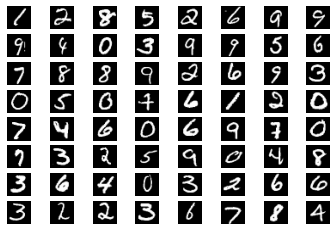

In [7]:
#@title Checking MNIST Dataloader: Looking at images
images, labels  = next(iter(train_mnist_loader))

figure = plt.figure()
for index in range(1, len(images) + 1): # assumption: batch size would be atleast 8
    plt.subplot(8, int(len(images)/8), index)
    plt.axis('off')
    # plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')
    unscaled_image = ((images[index-1].numpy()*std_dev + mean)*255).astype(np.uint8)
    plt.imshow(np.transpose(unscaled_image, (1, 2, 0)))
    # unscaled_image = images[index-1].numpy().astype(np.uint8)
    # plt.imshow(unscaled_image.permute(1,2,0))
    # plt.imshow(images[index-1].permute(1,2,0))
    # plt.imshow(unscaled_image)

In [8]:
#@title MNIST-M dataset related
"""Dataset setting and data loader for MNIST-M.

CREDIT: https://github.com/corenel;https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cogan/mnistm.py
"""

from __future__ import print_function

import errno
import os

import torch
import torch.utils.data as data
from PIL import Image


class MNISTM(data.Dataset):
    """`MNIST-M Dataset."""

    url = "https://github.com/VanushVaswani/keras_mnistm/releases/download/1.0/keras_mnistm.pkl.gz"

    raw_folder = "raw"
    processed_folder = "processed"
    training_file = "mnist_m_train.pt"
    test_file = "mnist_m_test.pt"

    def __init__(self, root, mnist_root="data", train=True, transform=None, target_transform=None, download=False):
        """Init MNIST-M dataset."""
        super(MNISTM, self).__init__()
        self.root = os.path.expanduser(root)
        self.mnist_root = os.path.expanduser(mnist_root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError("Dataset not found." + " You can use download=True to download it")

        if self.train:
            self.train_data, self.train_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.training_file)
            )
        else:
            self.test_data, self.test_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.test_file)
            )

    def __getitem__(self, index):
        """Get images and target for data loader.

        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.squeeze().numpy(), mode="RGB")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        """Return size of dataset."""
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file)) and os.path.exists(
            os.path.join(self.root, self.processed_folder, self.test_file)
        )

    def download(self):
        """Download the MNIST data."""
        # import essential packages
        from six.moves import urllib
        import gzip
        import pickle
        from torchvision import datasets

        # check if dataset already exists
        if self._check_exists():
            return

        # make data dirs
        try:
            os.makedirs(os.path.join(self.root, self.raw_folder))
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        # download pkl files
        print("Downloading " + self.url)
        filename = self.url.rpartition("/")[2]
        file_path = os.path.join(self.root, self.raw_folder, filename)
        if not os.path.exists(file_path.replace(".gz", "")):
            data = urllib.request.urlopen(self.url)
            with open(file_path, "wb") as f:
                f.write(data.read())
            with open(file_path.replace(".gz", ""), "wb") as out_f, gzip.GzipFile(file_path) as zip_f:
                out_f.write(zip_f.read())
            os.unlink(file_path)

        # process and save as torch files
        print("Processing...")

        # load MNIST-M images from pkl file
        with open(file_path.replace(".gz", ""), "rb") as f:
            mnist_m_data = pickle.load(f, encoding="bytes")
        mnist_m_train_data = torch.ByteTensor(mnist_m_data[b"train"])
        mnist_m_test_data = torch.ByteTensor(mnist_m_data[b"test"])

        # get MNIST labels
        mnist_train_labels = datasets.MNIST(root=self.mnist_root, train=True, download=True).train_labels
        mnist_test_labels = datasets.MNIST(root=self.mnist_root, train=False, download=True).test_labels

        # save MNIST-M dataset
        training_set = (mnist_m_train_data, mnist_train_labels)
        test_set = (mnist_m_test_data, mnist_test_labels)
        with open(os.path.join(self.root, self.processed_folder, self.training_file), "wb") as f:
            torch.save(training_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.test_file), "wb") as f:
            torch.save(test_set, f)

        print("Done!")

In [9]:
train_mean_std_dev_mnistm = MNISTM(
                          root = './',# directory where data needs to be stored
                          train = True, # get the training portion of the dataset
                          download = True, # downloads
                          transform = transforms.ToTensor()# converts to tesnor
                          )

Processing...
Done!


In [10]:
# Getting Mean and Standard Deviation of dataset MNISTM
imgs = [item[0] for item in train_mean_std_dev_mnistm]
imgs = torch.stack(imgs, dim=0).numpy()
# calculate mean over each channel (r,g,b)
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
mean_mnistm = (mean_r,mean_g,mean_b)

# calculate std over each channel (r,g,b)
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
std_dev_mnistm= (std_r,std_g,std_b)

print(f"mean : {mean_mnistm}   std_dev: {std_dev_mnistm}") #mean : (0.46387476, 0.46759155, 0.41990575)   std_dev: (0.25341642, 0.23800454, 0.26179394)

mean : (0.46387476, 0.46759155, 0.41990575)   std_dev: (0.25341642, 0.23800454, 0.26179394)


In [11]:
#@title Transforms for MNISTM

# Train Phase transformations
train_mnistm_transforms = transforms.Compose([
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)), # rotation of 7 degress may help | can be ignored
                                      #  transforms.Grayscale(num_output_channels=3),
                                       transforms.ToTensor(), # converts to tensor
                                       transforms.Normalize(mean_mnistm, std_dev_mnistm) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_mnistm_transforms = transforms.Compose([
                                      #  transforms.Grayscale(num_output_channels=3),
                                       transforms.ToTensor(),# converts to tensor
                                       transforms.Normalize(mean_mnistm, std_dev_mnistm)
                                       ])


In [12]:
#@title MNISTM dataset, train and test split, dataloader
train_mnistm = MNISTM('./data', # directory where data needs to be stored
                       train=True, # get the training portion of the dataset
                       download=True, # downloads
                       transform=train_mnistm_transforms)
test_mnistm = MNISTM('./data', 
                      train=False, 
                      download=True, 
                      transform=test_mnistm_transforms)


dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=64)

train_mnistm_loader = torch.utils.data.DataLoader(
    dataset=train_mnistm,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

test_mnistm_loader = torch.utils.data.DataLoader(
    dataset = test_mnistm,# test dataset 
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

Processing...
Done!


In [13]:
# list_std_dev_mnistm = (std_dev_mnistm)

tensor(6)
tensor([[[-4.0680e-01, -6.6987e-01, -6.8535e-01,  ..., -9.1747e-01,
          -6.3892e-01, -8.5557e-01],
         [-3.9133e-01, -9.0200e-01, -8.7105e-01,  ..., -7.9367e-01,
          -7.7820e-01, -8.4010e-01],
         [-4.8418e-01, -9.0200e-01, -7.6272e-01,  ..., -6.5440e-01,
          -9.0200e-01, -8.7105e-01],
         ...,
         [ 1.8525e+00,  1.9918e+00,  2.1156e+00,  ...,  2.1156e+00,
           1.6513e+00,  1.6978e+00],
         [ 2.0692e+00,  2.1156e+00,  2.1156e+00,  ...,  1.8525e+00,
           1.6049e+00,  1.7132e+00],
         [ 1.9454e+00,  1.4502e+00,  2.1156e+00,  ...,  1.3264e+00,
           1.9608e+00,  1.7442e+00]],

        [[-4.3228e-01, -7.2887e-01, -7.4534e-01,  ..., -1.0090e+00,
          -7.1239e-01, -9.5954e-01],
         [-4.1581e-01, -9.7602e-01, -9.2659e-01,  ..., -8.7716e-01,
          -8.6068e-01, -9.4307e-01],
         [-5.1467e-01, -9.5954e-01, -8.1125e-01,  ..., -7.2887e-01,
          -9.9250e-01, -9.7602e-01],
         ...,
         [ 2.02

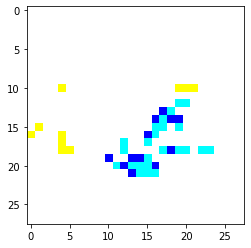

In [19]:
#@title Checking MNISTM Dataloader: Looking at images
images, labels  = next(iter(train_mnistm_loader))
print(labels[0])
print(images[0])
print(images[0].shape)
denorm_img =  np.random.random((3,28,28))
print(denorm_img)
for i in range(3):
  denorm_img[i,:,:] = (images[0][i,:,:].numpy()*std_dev_mnistm[i]*255+mean_mnistm[i]*255).astype(np.uint8) 
plt.imshow(np.transpose(denorm_img, (1, 2, 0)))
print(images[0])
print(images[0].shape)

In [21]:
import math
import itertools

import numpy as np
import matplotlib.pyplot as plt


def tensors_as_images(tensors, nrows=1, figsize=(8, 8), titles=[],
                      wspace=0.1, hspace=0.2, cmap=None):
    """
    Plots a sequence of pytorch tensors as images.

    :param tensors: A sequence of pytorch tensors, should have shape CxWxH
    """
    assert nrows > 0

    num_tensors = len(tensors)

    ncols = math.ceil(num_tensors / nrows)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,
                             gridspec_kw=dict(wspace=wspace, hspace=hspace),
                             subplot_kw=dict(yticks=[], xticks=[]))
    axes_flat = axes.reshape(-1)

    # Plot each tensor
    for i in range(num_tensors):
        ax = axes_flat[i]

        image_tensor = tensors[i]
        assert image_tensor.dim() == 3  # Make sure shape is CxWxH

        image = image_tensor.numpy()
        image = image.transpose(1, 2, 0)
        image = image.squeeze()  # remove singleton dimensions if any exist

        # Scale to range 0..1
        min, max = np.min(image), np.max(image)
        image = (image-min) / (max-min)

        ax.imshow(image, cmap=cmap)

        if len(titles) > i and titles[i] is not None:
            ax.set_title(titles[i])

    # If there are more axes than tensors, remove their frames
    for j in range(num_tensors, len(axes_flat)):
        axes_flat[j].axis('off')

    return fig, axes


def dataset_first_n(dataset, n, show_classes=False, class_labels=None,
                    random_start=True, **kw):
    """
    Plots first n images of a dataset containing tensor images.
    """

    if random_start:
        start = np.random.randint(0, len(dataset) - n)
        stop = start + n
    else:
        start = 0
        stop = n

    # [(img0, cls0), ..., # (imgN, clsN)]
    first_n = list(itertools.islice(dataset, start, stop))

    # Split (image, class) tuples
    first_n_images, first_n_classes = zip(*first_n)

    if show_classes:
        titles = first_n_classes
        if class_labels:
            titles = [class_labels[cls] for cls in first_n_classes]
    else:
        titles = []

    return tensors_as_images(first_n_images, titles=titles, **kw)

(<Figure size 576x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

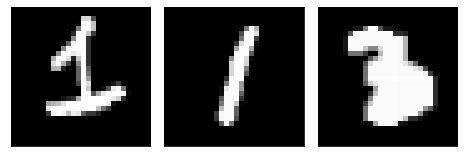

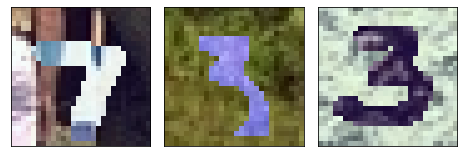

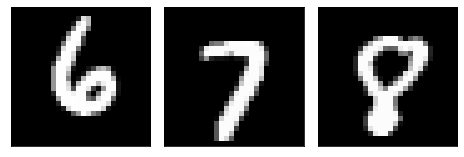

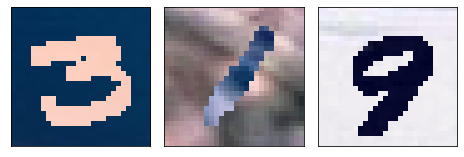

In [24]:
## Showing first n images of the dataset
dataset_first_n(train_mnist, 3, cmap='gray')
dataset_first_n(train_mnistm, 3)
dataset_first_n(test_mnist, 3, cmap='gray')
dataset_first_n(test_mnistm, 3)

In [141]:
#@title Checking MNISTM Dataloader: Looking at images
images, labels  = next(iter(train_mnistm_loader))
print(labels[0])
print(images[0])
print(images[0].shape)
print(torch.matmul(images[0],torch.tensor(std_dev_mnistm).T))
#################
# print(type(images[0]))
# print(labels[0])
# print(images[0])
# # images_de = torch.zeros_like(images[0])
# # print(images[0].numpy()*np.asarray(std_dev_mnistm).T)
# for dim in range(len(list(std_dev_mnistm))):
#   # images_de[dim] = torch.tensor((images[0][dim].numpy()*std_dev_mnistm[dim]*255+mean_mnistm[dim]*255).astype(np.uint8))
#   images_de[dim] = (images[0][dim].numpy()*std_dev_mnistm[dim]*255+mean_mnistm[dim]*255).astype(np.uint8)
# print(images_de)
# print(images_de.shape)
# plt.imshow(images_de.permute(1,2,0).numpy())
##################
# figure = plt.figure()
# for index in range(1, len(images) + 1): # assumption: batch size would be atleast 8
#     plt.subplot(8, int(len(images)/8), index)
#     plt.axis('off')
#     # plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')
#     unscaled_image = ((images[index-1].numpy()*std_dev_mnistm + mean_mnistm)*255).astype(np.uint8)
#     plt.imshow(np.transpose(unscaled_image, (1, 2, 0)))
#     # unscaled_image = images[index-1].numpy().astype(np.uint8)
#     # plt.imshow(unscaled_image.permute(1,2,0))
#     # plt.imshow(images[index-1].permute(1,2,0))
#     # plt.imshow(unscaled_image)

tensor(0)
tensor([[[-0.0973, -0.0664, -0.0818,  ..., -0.1902, -0.0199,  0.0574],
         [-0.0045, -0.0664, -0.0818,  ..., -0.0199,  0.0884,  0.0884],
         [ 0.1503,  0.0884, -0.0045,  ...,  0.0110,  0.0884,  0.0420],
         ...,
         [-0.1437, -0.0354,  0.2431,  ..., -0.1902, -0.0818, -0.1283],
         [ 0.0574,  0.1812,  0.1967,  ..., -0.2211,  0.0265, -0.0199],
         [ 0.0884,  0.1039,  0.0420,  ..., -0.2056, -0.0354, -0.1902]],

        [[-0.0039, -0.0039, -0.0204,  ..., -0.0863,  0.0950,  0.1609],
         [ 0.0620, -0.0039, -0.0698,  ...,  0.0785,  0.1938,  0.1609],
         [ 0.1774,  0.1115,  0.0126,  ...,  0.0950,  0.1774,  0.0785],
         ...,
         [-0.0698,  0.0455,  0.2762,  ..., -0.1357, -0.0698, -0.1192],
         [ 0.0950,  0.2268,  0.2927,  ..., -0.1687,  0.0455, -0.0039],
         [ 0.1279,  0.1444,  0.1279,  ..., -0.1522,  0.0291, -0.1357]],

        [[-0.4355, -0.4355, -0.4505,  ..., -0.4805, -0.3157, -0.2858],
         [-0.3606, -0.4206, -0.4805

RuntimeError: ignored

[[[70 69 70 ... 62 62 62]
  [68 67 68 ... 61 60 60]
  [67 65 65 ... 58 58 57]
  ...
  [46 46 46 ... 55 56 55]
  [47 47 47 ... 56 56 56]
  [50 49 49 ... 58 57 58]]

 [[79 78 79 ... 70 70 70]
  [77 76 77 ... 69 68 68]
  [76 74 74 ... 66 66 65]
  ...
  [55 55 55 ... 61 62 61]
  [56 56 56 ... 62 62 62]
  [59 58 58 ... 64 63 64]]

 [[84 83 84 ... 73 73 73]
  [82 81 82 ... 72 71 71]
  [81 79 79 ... 69 69 68]
  ...
  [54 54 54 ... 61 62 61]
  [55 55 55 ... 62 62 62]
  [58 57 57 ... 64 63 64]]]


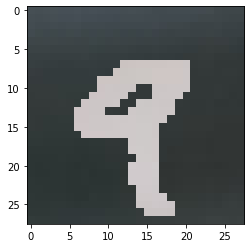

In [92]:
unscaled_image = ((train_mean_std_dev_mnistm[4][0].numpy())*255).astype(np.uint8)
print(unscaled_image)
plt.imshow(np.transpose(unscaled_image, (1, 2, 0)))

In [99]:
train_mean_std_dev_mnistm.

__main__.MNISTM

In [145]:
torch.tensor(std_dev_mnistm).shape

torch.Size([3])

In [167]:

tensor1 = torch.randn(3, 4)
print(tensor1.shape)
tensor2 = torch.randn(4)
print(tensor2.shape)
torch.matmul(tensor1, tensor2).shape


images, labels  = next(iter(train_mnistm_loader))
print(images[0])
print(images[0][0])
# for i in range(3):
#   print(images[0][i])
# print(labels[0])
# print(images[0])
print(images[0].shape)
b = torch.tensor(std_dev_mnistm).unsqueeze(dim=1).unsqueeze(dim=2)
print(b.shape)
print(torch.matmul(images[0],b.T))

torch.Size([3, 4])
torch.Size([4])
tensor([[[ 0.5062,  0.5681,  0.5836,  ..., -1.0877, -1.0877, -1.1032],
         [ 0.6919,  0.6919,  0.6764,  ..., -1.1186, -1.0877, -1.1032],
         [ 0.6610,  0.7229,  0.7383,  ..., -1.1341, -1.1186, -1.0567],
         ...,
         [ 0.6455,  0.5991,  0.5991,  ...,  1.9608,  1.9918,  1.1097],
         [ 0.7074,  0.5836,  0.6300,  ...,  2.0227,  1.9608,  2.0846],
         [ 0.6300,  0.5836,  0.7383,  ...,  2.0227,  2.1001,  1.9608]],

        [[ 0.3092,  0.3257,  0.3751,  ..., -1.1078, -1.1078, -1.1243],
         [ 0.5069,  0.4575,  0.4080,  ..., -1.1737, -1.1408, -1.1573],
         [ 0.4575,  0.4904,  0.4904,  ..., -1.1902, -1.2067, -1.1078],
         ...,
         [ 0.4410,  0.3586,  0.3586,  ...,  1.9898,  2.0392,  1.1165],
         [ 0.5069,  0.3421,  0.3586,  ...,  2.0228,  1.9569,  2.1381],
         [ 0.4245,  0.3421,  0.4739,  ...,  2.0063,  2.0887,  2.0063]],

        [[-0.3307, -0.3007, -0.2109,  ..., -1.0347, -1.0347, -1.0497],
         [

RuntimeError: ignored

In [98]:

def get_mean_std_dev_mnistm(dataset):
  """ Supports only 1 and 3 channel images
  """
  data = dataset # data is numpy array
  print(data.shape)
  
  assert dataset[0][0].shape[0] in [1,3], "Supports only 1 and 3 channel images"

  if dataset[0][0].shape[0]==3:
    mean = data.mean(axis = (0,1,2))
    std = data.std(axis = (0,1,2))

  return mean, std


mean_mnistm, std_dev_mnistm = get_mean_std_dev_mnistm(train_mean_std_dev_mnistm)
print(f"mean : {mean_mnistm}   std_dev: {std_dev_mnistm}")

AttributeError: ignored